In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow.keras.backend as K
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import os
from PIL import Image
import sys
from models import u_net_mod_lev


In [20]:
print(tf.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf


In [2]:
available_losses = [
    'categorical_crossentropy',
    'classical_jaccard',
    'jaccard_power_15', # p = 1.5
    'jaccard_power_20', # p = 2
]

In [3]:
selected_loss = available_losses[3]
print(selected_loss)

jaccard_power_20


In [34]:
pwd

'/home/dduque/Dropbox/PHD/phd/Code/code/ColorLines/Notebook/2019/2A/Deep/Power_jaccard_code'

In [4]:
print("tf antes", tf.keras.backend.image_data_format())
tf.keras.backend.set_image_data_format("channels_last")
print("tf despues", tf.keras.backend.image_data_format())

tf antes channels_first
tf despues channels_last


In [5]:
base_path = '/data/Datasets2020/power_losses/mixed_mnist/v17/'

nb_filters = 8
batch_size = 10

epochs = 100
num_samples_train = 1000

In [6]:
def get_time():
    import datetime
    return datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")


def jaccard_pow_loss(y_true, y_pred, p_value=2.0,smooth = 10):
    p_value = POWER_VALUE
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    term_true = K.sum(K.pow(y_true_f, p_value))
    term_pred = K.sum(K.pow(y_pred_f, p_value))
    union = term_true + term_pred - intersection
    return 1 - ((intersection + smooth) / (union + smooth))


In [7]:
print(selected_loss)

jaccard_power_20


In [8]:
if selected_loss == 'categorical_crossentropy':
    loss = selected_loss
    POWER_VALUE = 0.0
elif selected_loss == 'classical_jaccard':
    loss = jaccard_pow_loss
    POWER_VALUE = 1.0
elif selected_loss == 'jaccard_power_15':
    loss = jaccard_pow_loss
    POWER_VALUE = 1.5
elif selected_loss == 'jaccard_power_20':
    loss = jaccard_pow_loss
    POWER_VALUE = 2.0    
print("loss_string", selected_loss)
print("p_value", POWER_VALUE)
print("filters", nb_filters)
print("batch_size", batch_size)

loss_string jaccard_power_20
p_value 2.0
filters 8
batch_size 10


In [9]:
noise_rate = 0.1
num_samples_val = int(num_samples_train*0.2)
patience_epochs = 5
test_name = get_time()
conv_sampling = True
HEIGHT, WIDTH = 32, 32
N_CLASSES = 10

In [10]:
base_path_train = base_path + 'train'
pathimagetrain = base_path_train +'/images/'
pathgttrain= base_path_train + '/gt/'

base_path_validation = base_path + 'validation'
pathimageval = base_path_validation +'/images/'
pathgtval= base_path_validation + '/gt/'

def generator_from_list(path_to_images, list_of_images, path_to_gt, num_classes, is_train_set = True, batch_size = 1):
    X_return, Y_return = np.empty([batch_size, WIDTH, HEIGHT, 1]), np.empty([batch_size, WIDTH, HEIGHT, N_CLASSES])
    i_sample = 0
    while True:
        random_index = np.random.choice(len(list_of_images))
        file_name = list_of_images[random_index]
        #print(is_train_set, "reading:", file_name)
        I_img = Image.open(path_to_images + file_name).convert('RGB')
        I = np.array(I_img)/255.

        gt_file_name = file_name.split('.')[0] + '.npy'
        Y = np.load(path_to_gt+gt_file_name)

        X = I[:,:,0]

        X=np.expand_dims(X,axis=2)

        Y = Y[:,:,:-1] # discard channel of background
        
        X_return[i_sample,:,:,:] = X
        Y_return[i_sample,:,:,:] = Y
        i_sample += 1
        if i_sample == batch_size:
            #print(np.unique(X_return), np.unique(Y_return))
            yield X_return,Y_return
            X_return, Y_return = np.empty([batch_size, WIDTH, HEIGHT, 1]), np.empty([batch_size, WIDTH, HEIGHT, N_CLASSES])
            i_sample = 0        


In [11]:
list_train_images = os.listdir(pathimagetrain)
list_train_images.sort()
list_train_images = list_train_images[:num_samples_train]

list_validation_images = os.listdir(pathimageval)
list_validation_images.sort()
list_validation_images = list_validation_images[:num_samples_val]

print("list_train_images", len(list_train_images) )
print("list_train_images", len(list_validation_images) )

list_train_images 1000
list_train_images 200


In [12]:
train_generator = generator_from_list(pathimagetrain, list_train_images, pathgttrain, N_CLASSES, is_train_set=True, batch_size=batch_size)
val_generator = generator_from_list(pathimageval, list_validation_images, pathgtval, N_CLASSES, is_train_set=False, batch_size=batch_size)

In [13]:
model = u_net_mod_lev((HEIGHT, WIDTH, 1), nb_levels = 4, nb_filters_0 = nb_filters, output_channels = N_CLASSES, sigma_noise = noise_rate, conv_sampling = conv_sampling)
model.summary()

model.compile(loss=loss,
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

cb = [
    EarlyStopping(monitor='val_loss', patience=patience_epochs, verbose=0, mode='min'),
    #ModelCheckpoint(output_model, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min'),
    #CSVLogger(csv_path, separator=',', append=True)
]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 8)    0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 8)    584         activation[0][0]                 
__________________________________________________________________________________________________
activation

In [14]:
H = model.fit_generator(train_generator,
                    epochs=epochs, 
                    steps_per_epoch = num_samples_train // batch_size,
                    validation_data=val_generator,
                    validation_steps=num_samples_val // batch_size,
                    callbacks= cb,
                    verbose=2
         )

Epoch 1/100
 - 5s - loss: 0.9495 - acc: 0.7863 - val_loss: 0.9366 - val_acc: 0.8479
Epoch 2/100
 - 3s - loss: 0.9312 - acc: 0.8643 - val_loss: 0.9123 - val_acc: 0.8777
Epoch 3/100
 - 3s - loss: 0.8171 - acc: 0.7719 - val_loss: 0.7660 - val_acc: 0.7601
Epoch 4/100
 - 3s - loss: 0.7436 - acc: 0.3583 - val_loss: 0.6849 - val_acc: 0.5705
Epoch 5/100
 - 3s - loss: 0.7016 - acc: 0.5903 - val_loss: 0.6829 - val_acc: 0.6673
Epoch 6/100
 - 3s - loss: 0.6747 - acc: 0.2833 - val_loss: 0.6441 - val_acc: 0.1395
Epoch 7/100
 - 3s - loss: 0.6315 - acc: 0.0979 - val_loss: 0.6924 - val_acc: 0.0511
Epoch 8/100
 - 3s - loss: 0.5981 - acc: 0.0969 - val_loss: 0.5653 - val_acc: 0.1036
Epoch 9/100
 - 3s - loss: 0.5387 - acc: 0.1200 - val_loss: 0.4965 - val_acc: 0.1266
Epoch 10/100
 - 3s - loss: 0.4881 - acc: 0.1318 - val_loss: 0.4840 - val_acc: 0.1322
Epoch 11/100
 - 3s - loss: 0.4472 - acc: 0.1267 - val_loss: 0.4922 - val_acc: 0.1283
Epoch 12/100
 - 3s - loss: 0.4070 - acc: 0.1375 - val_loss: 0.4206 - val_a

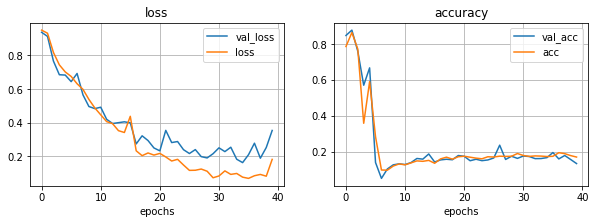

In [15]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("loss")
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['loss'], label='loss')
plt.xlabel("epochs")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(H.history['val_acc'], label='val_acc')
plt.plot(H.history['acc'], label='acc')
plt.legend()
plt.xlabel("epochs")
plt.grid()
plt.show()

## Evaluate model on test data

In [16]:
def build_arrays_from_path(path_to_img, path_to_gt):
    y_list = list()
    x_list = list()
    list_of_names = os.listdir(path_to_img)
    list_of_names.sort()
    for filename in list_of_names:
        I_img = Image.open(path_to_img+filename).convert('RGB')
        I = np.array(I_img)/255.
        gt_file_name = filename.split('.')[0] + '.npy'
        Y = np.load(path_to_gt+gt_file_name)
        Y = Y[:,:,:-1]

        x_list.append(I[:,:,0].reshape([I.shape[0], I.shape[1], 1]))
        y_list.append(Y)    

    return np.array(x_list), np.array(y_list)



base_path_test = base_path + 'test'
pathimagetest = base_path_test +'/images/'
pathgttest= base_path_test + '/gt/'

xtest, ytest = build_arrays_from_path(pathimagetest, pathgttest)


In [32]:
i = np.random.randint(xtest.shape[0])
sample_to_predict = xtest[i,:,:,:]
sample_to_predict = np.expand_dims(sample_to_predict, 0)
y_pred = model.predict(sample_to_predict)

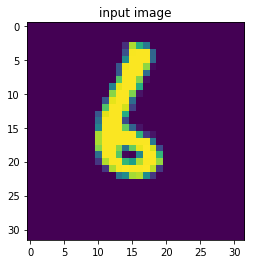

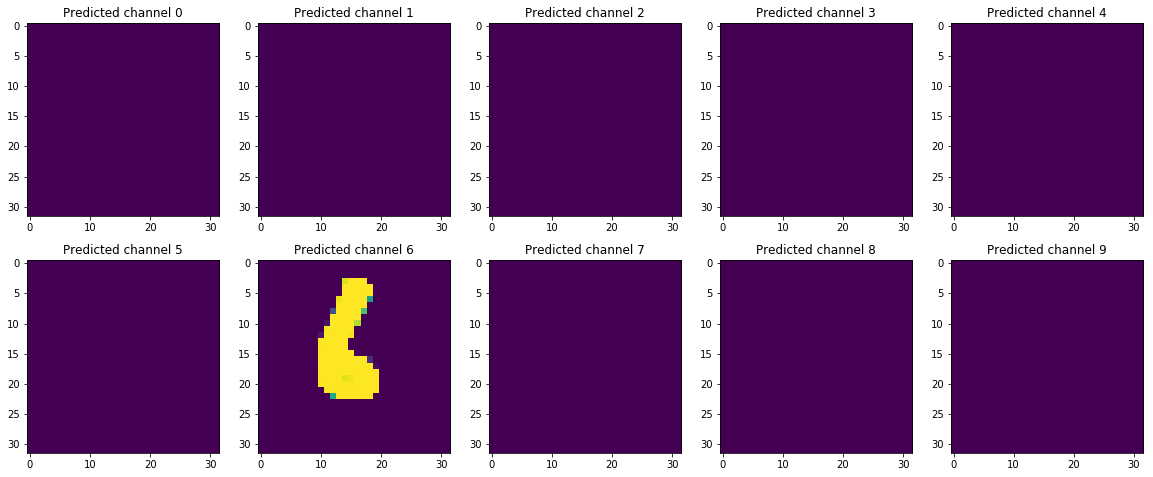

In [33]:
plt.title("input image")
plt.imshow(sample_to_predict[0,:,:,0])
plt.show()
y_sample = ytest[i,:,:,:]

plt.figure(figsize=(20,8))
for j in range(N_CLASSES):
    plt.subplot(2,5,j + 1)
    plt.title("Predicted channel " + str(j))
    plt.imshow(y_pred[0,:,:,j], vmin=0, vmax=1)
plt.show()